# SC DOT Data and Zillow Home Sales - How has traffic in South Carolina changed?

One of my least favorite parts of the day is my daily commute. Anecdotally, I feel as if traffic has worsened/increased in South Carolina since I moved here in 2007, and it's worsening at an increasing rate every year.
I stumbled across some data on the SC-DOT GIS page that I thought might help confirm or deny my suspicion.
<a href="https://www.scdot.org/travel/travel-mappinggis.aspx"> Here's </a> where the data can be downloaded.
The data in question that I'm examining are Annual Average Daily Traffic counts from the years 2009 - 2018.
These data are recorded at the level of StationID and RouteIdentifier with additional information as well, including Latitude and Longitude of the recording Station.
I downloaded the .zip files for each separately and then renamed them and put them into one folder - shp_files.
The data come in both .shp and .dbf (Xbase) format.
More about these file types here:
TODO

SCDOT has some interactive ArcGIS maps with these data points plotted already <a href="http://scdot.maps.arcgis.com/apps/MinimalGallery/index.html?appid=7420aa1f39d84400a6d7e8cdaacc89cd"> here. </a>

However, these plots don't fully convey (to me) the true amount of traffic in SC, as all station points are plotted as little cars with no information about AADT, nor the change in traffic patterns year over year.
Nor do they address any underlying causes of what may be driving potential traffic pattern changes.

Tangentially, SCDOT does provide a wealth of other data for citizens to browse, some of which look quite <a href="http://scdot.maps.arcgis.com/apps/MinimalGallery/index.html?appid=e8ace63de0e6423394d04c9c091e893b#reas"> interesting. </a> I am particularly interested in how the "South Carolina Roads by Pavement Status" dataset folds into the questions at hand here, but that goes beyond the scope of this post. Perhaps to be addressed later.

Getting back on topic, one of the most intuitive drivers of change in traffic patterns could be popluation growth/decline in the areas nearby. I chose to use a data set from Zillow - https://www.zillow.com/research/data/ - that details Monthly Home Sales by ZipCode as a proxy to population growth per Zip Code.

Finally, I also downloaded a data set from <a href="https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/"> OpenDataSoft </a> that cross references ZipCode to latitude and longitude. I only downloaded data for South Carolina.


### Questions to Answer:

1) What do the data look like and what does it take to get them in a unified format?

2) Has overall traffic increased in SC over the past 10 years?

3) Are there are any areas in SC that show more aggressive traffic growth?

4) Does number of home sales in Zip Codes within a certain radius of a station (e.g. 50 km) have any bearing on traffic numbers the next or same year?

In [1]:
# import required libraries

import pandas as pd
import numpy as np
from simpledbf import Dbf5
import os
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go

In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [3]:
# read GIS dbf data into dataframes, one file for each year between 2009 and 2018
shp_dfs = {}
for root, dirs, files in os.walk("./shp_files"):
    for file in files:
        if file.endswith(".dbf"):
            # print(file.split('.')[0])
            dbf = Dbf5(os.path.join(root, file))
            df = dbf.to_dataframe()
            shp_dfs[file.split('.')[0]] = df

In [4]:
# give an ol look see at the most recent year
shp_dfs['2018'].head()

,CountyNumb,RouteTypeN,RouteType1,RouteNumbe,MeterMileP,BeginMileP,EndMilePoi,StationNum,Termini,FactoredAA,FactoredA1,MapLRS,Status1,ID1,RouteAuxil,CountyName,Long,Lat
0,1.0,2.0,US,178.0,1.196,0.00,3.82,101.0,County Line - ANDERSON TO S- 166 (DRAKE RD),4300.0,2018.0,01020017800E,NaN,1,NaN,ABBEVILLE,-82.38521,34.41979
1,1.0,2.0,US,178.0,4.345,3.82,4.91,103.0,S- 166 (DRAKE RD) TO SC 184 (MAIN ST W),4600.0,2018.0,01020017800E,NaN,2,NaN,ABBEVILLE,-82.35324,34.38344
2,1.0,2.0,US,178.0,5.633,4.91,7.28,105.0,SC 184 (MAIN ST W) TO County Line - GREENWOOD,3600.0,2018.0,01020017800E,NaN,3,NaN,ABBEVILLE,-82.33765,34.37099
3,1.0,4.0,SC,20.0,0.074,0.00,0.18,109.0,"SC 203 (WASHINGTON ST), L- 20, L- 980 TO SC 71...",4900.0,2018.0,01040002000E,NaN,4,NaN,ABBEVILLE,-82.38017,34.17889
4,1.0,4.0,SC,20.0,0.439,0.18,0.45,111.0,SC 71 (N MAIN ST) TO L- 170 (RICHEY ST),2200.0,2018.0,01040002000E,NaN,5,NaN,ABBEVILLE,-82.38114,34.18369


Just by eyeballing, it can be surmised what each field name means, along with the helpful data dictionary supplied by SCDOT.
For example "FactoredA1" is clearly the year of this particular dataset, while "Long" and "Lat" hold the longitude and latitude of the datapoint.

Next, we'll check to see if the column names match across all the dataframes we have, one for each year.

In [5]:
# check if the columns in the dfs match - per df, convert columns to sets. Check the intersection of all sets.
col_sets = map(lambda x: set(x.columns), shp_dfs.values())

In [6]:
# unpack the list of column sets into set.intersection, which returns common elements in set
common_cols = set.intersection(*col_sets)

In [7]:
# check to see what's common between the dfs
common_cols

{'ID1'}

Uh oh! There's only one column that is common between all of the dataframes. Let's dig in a little more.

In [8]:
# Let's check to see what the actual columns are named and how many there are
for df in shp_dfs.values():
    print(df.columns, len(df.columns))

Index(['STATION', 'MILE_POINT', 'ROUTE_LRS', 'MAP_TYPE', 'ID1', 'LATITUDE',
       'LONGITUDE', 'COUNTY_ID', 'ATR_NUM', 'County', 'Station_Nu',
       'Route_Type', 'Route_Numb', 'AUX', 'Count', 'Year', 'Descriptio',
       'GMRotation'],
      dtype='object') 18
Index(['STATION_NU', 'MILE_POINT', 'ROUTE_LRS', 'MAP_TYPE', 'LATITUDE',
       'LONGITUDE', 'COUNTY_ID', 'ROUTE_TYPE', 'ROUTE_NUMB', 'ROUTE_AUX',
       'COUNT', 'YEAR', 'DESCRIPTIO', 'ID1', 'GMRotation'],
      dtype='object') 15
Index(['STATION_NU', 'COUNT', 'DESCRIPTIO', 'YEAR', 'ROUTE_TYPE', 'ROUTE_NUMB',
       'ROUTE_AUX', 'MILE_POINT', 'ROUTE_LRS', 'COUNTY_ID', 'MAP_TYPE',
       'LATITUDE', 'LONGITUDE', 'ID1', 'GMRotation'],
      dtype='object') 15
Index(['STATION', 'MILE_POINT', 'ROUTE_LRS', 'MAP_TYPE', 'ID1', 'LATITUDE',
       'LONGITUDE', 'COUNTY_ID', 'county', 'F2', 'station1', 'rtetype',
       'rtenumb', 'rteaux', 'bmp', 'emp', 'termini', 'rtelrs', 'CONNN', 'aadt',
       'aadtyr', 'GMRotation'],
      dtype='o

We can immediately see that we have different numbers of columns per year, and that most of the columns are all named differently. We'll try to address that. First we'll try to do some simple string cleaning on the column names.

In [9]:
# maybe we'll get better results if we do some simple string formatting first
for df in shp_dfs.values():
    df.columns = [c.replace('_', '').lower().strip() for c in df.columns]

In [10]:
# check set intersection again
col_sets = list(map(lambda x: set(x.columns), shp_dfs.values()))
set.intersection(*col_sets)

{'id1'}

Still only one column that's the same! Time to do some brute-force mapping.

In [11]:
# eye all the column names
for year, df in shp_dfs.items():
    print(year, df.columns, len(df.columns))

2009 Index(['station', 'milepoint', 'routelrs', 'maptype', 'id1', 'latitude',
       'longitude', 'countyid', 'atrnum', 'county', 'stationnu', 'routetype',
       'routenumb', 'aux', 'count', 'year', 'descriptio', 'gmrotation'],
      dtype='object') 18
2010 Index(['stationnu', 'milepoint', 'routelrs', 'maptype', 'latitude',
       'longitude', 'countyid', 'routetype', 'routenumb', 'routeaux', 'count',
       'year', 'descriptio', 'id1', 'gmrotation'],
      dtype='object') 15
2011 Index(['stationnu', 'count', 'descriptio', 'year', 'routetype', 'routenumb',
       'routeaux', 'milepoint', 'routelrs', 'countyid', 'maptype', 'latitude',
       'longitude', 'id1', 'gmrotation'],
      dtype='object') 15
2012 Index(['station', 'milepoint', 'routelrs', 'maptype', 'id1', 'latitude',
       'longitude', 'countyid', 'county', 'f2', 'station1', 'rtetype',
       'rtenumb', 'rteaux', 'bmp', 'emp', 'termini', 'rtelrs', 'connn', 'aadt',
       'aadtyr', 'gmrotation'],
      dtype='object') 22
2013

We can create a dictionary to rename columns.

In [12]:
# create a dictionary that will allow us to rename columns from key to value.
# we won't map every column - only keep a subset
col_mapping_dict = {
    **dict.fromkeys(['station', 'stationnu', 'stationnum'], 'station_id'),
    **dict.fromkeys(['milepoint', 'metermile', 'metermilep'], 'route_mile_point'),
    **dict.fromkeys(['latitude', 'lat'], 'latitude'),
    **dict.fromkeys(['longitude', 'long'], 'longitude'), 
    **dict.fromkeys(['aadtyr', 'year', 'factored1', 'factoreda1'], 'year'),
    **dict.fromkeys(['routelrs', 'maplrs'], 'route_identifier'),
    **dict.fromkeys(['termini', 'descriptio'], 'route_leg_descrip'),
    **dict.fromkeys(['beginmilep', 'beginmile', 'bmp'], 'route_leg_beginmile'),
    **dict.fromkeys(['endmilepo', 'endmilepoi', 'emp'], 'route_leg_endmile'),
    **dict.fromkeys(['routetype', 'rtetype', 'routetypen', 'routetype1'], 'route_type'),   # has to be a numeric column as well, some collision here
    **dict.fromkeys(['rtenum', 'rtenumb', 'routenumb', 'routenum', 'routenumbe'], 'route_number'),
    **dict.fromkeys(['county', 'countyname', 'countynam'], 'county_name'),
    **dict.fromkeys(['countyid', 'countynumb'], 'county_id'),
    **dict.fromkeys(['aadt', 'factoreda', 'count', 'factoredaa'], 'average_daily_traffic'),
    **dict.fromkeys(['id1'], 'row_number')
}

In [13]:
# rename columns as per mapping dict
shp_dfs_renamed = {year: df.rename(columns=col_mapping_dict) for year, df in shp_dfs.items()}

In [14]:
for year, df in shp_dfs_renamed.items():
    print(year)
    print(df.dtypes)
    print('\n')

2009
station_id               float64
route_mile_point         float64
route_identifier          object
maptype                   object
row_number                 int64
latitude                  object
longitude                 object
county_id                  int64
atrnum                   float64
county_name              float64
station_id               float64
route_type               float64
route_number             float64
aux                      float64
average_daily_traffic    float64
year                     float64
route_leg_descrip         object
gmrotation               float64
dtype: object


2010
station_id               float64
route_mile_point         float64
route_identifier          object
maptype                   object
latitude                  object
longitude                 object
county_id                  int64
route_type                object
route_number             float64
routeaux                  object
average_daily_traffic    float64
year             

Unfortunately there's some collision on column names, with the primary offenders being route_type and county_id. By this I mean that the original column name can mean different things in the different dataframes. For route_type that means it can be a string (e.g. US) or a route type number (e.g. 1)
We'll handle the route_type columns that should be renamed below.

In [15]:
# rename route_type column only if it's a float
for year, df in shp_dfs_renamed.items():
    # create a df of column names and dtypes
    col_dtypes = df.dtypes.reset_index()
    col_dtypes.columns = ['col_name', 'dtype']
    # create a boolean mask with the criteria
    col_mask = (col_dtypes['col_name'] == 'route_type') & (col_dtypes['dtype'] == 'float64')
    # use integer indexing to rename the correct column 
    new_cols = np.array(df.columns)
    new_cols[col_mask] = 'route_type_number'
    df.columns = new_cols

In [16]:
shp_dfs_renamed['2018'].head()

,county_id,route_type_number,route_type,route_number,route_mile_point,route_leg_beginmile,route_leg_endmile,station_id,route_leg_descrip,average_daily_traffic,year,route_identifier,status1,row_number,routeauxil,county_name,longitude,latitude
0,1.0,2.0,US,178.0,1.196,0.00,3.82,101.0,County Line - ANDERSON TO S- 166 (DRAKE RD),4300.0,2018.0,01020017800E,NaN,1,NaN,ABBEVILLE,-82.38521,34.41979
1,1.0,2.0,US,178.0,4.345,3.82,4.91,103.0,S- 166 (DRAKE RD) TO SC 184 (MAIN ST W),4600.0,2018.0,01020017800E,NaN,2,NaN,ABBEVILLE,-82.35324,34.38344
2,1.0,2.0,US,178.0,5.633,4.91,7.28,105.0,SC 184 (MAIN ST W) TO County Line - GREENWOOD,3600.0,2018.0,01020017800E,NaN,3,NaN,ABBEVILLE,-82.33765,34.37099
3,1.0,4.0,SC,20.0,0.074,0.00,0.18,109.0,"SC 203 (WASHINGTON ST), L- 20, L- 980 TO SC 71...",4900.0,2018.0,01040002000E,NaN,4,NaN,ABBEVILLE,-82.38017,34.17889
4,1.0,4.0,SC,20.0,0.439,0.18,0.45,111.0,SC 71 (N MAIN ST) TO L- 170 (RICHEY ST),2200.0,2018.0,01040002000E,NaN,5,NaN,ABBEVILLE,-82.38114,34.18369


In [17]:
# still some collision - column name can mean different things in different years.
# drop some columns that still aren't right
shp_dfs_renamed['2009'].drop(['county_name'], axis=1, inplace=True)
shp_dfs_renamed['2012'].drop(['county_name'], axis=1, inplace=True)
shp_dfs_renamed['2017'].drop('county_name', axis=1, inplace=True)

In [18]:
# drop columns that are duplicated
for year, df in shp_dfs_renamed.items():
    df = df.loc[:, ~df.columns.duplicated()]
    shp_dfs_renamed[year] = df

Check for duplicates across our identity columns

In [19]:
# drop duplicated rows in dataframes
# some rows are only unique based on row_number (id1) and id2 fields
for year, df in shp_dfs_renamed.items():
    df = df.drop('row_number', axis=1)
    if 'id2' in df.columns:
        df = df.drop('id2', axis=1)
    df = df.drop_duplicates()
    shp_dfs_renamed[year] = df

In [20]:
for year, df in shp_dfs_renamed.items():
    df['group_num'] = df.groupby(['station_id','route_identifier', 'route_number']).average_daily_traffic.transform(np.size)

In [21]:
for year, df in shp_dfs_renamed.items():
    print(year)
    print(df.loc[df.group_num > 1].head())
    print('\n')

2009
      station_id  route_mile_point route_identifier maptype       latitude  \
2297       331.0             0.566     11070020900N  COUNTY  35:03:00.0546   
2298       331.0             0.566     11070020900N  COUNTY  35:03:00.8678   

           longitude  county_id  atrnum  route_type_number  route_number  aux  \
2297   -81:28:47.765         11     NaN                7.0         209.0  0.0   
2298  -81:28:48.9568         11     NaN                7.0         209.0  0.0   

      average_daily_traffic    year          route_leg_descrip  gmrotation  \
2297                  250.0  2009.0  York County Line TO S-121    0.000002   
2298                  250.0  2009.0  York County Line TO S-121    0.000002   

      group_num  
2297        2.0  
2298        2.0  


2010
      station_id  route_mile_point route_identifier              maptype  \
532       2601.0            22.823     02010052000E        NORTH AUGUSTA   
533       2601.0            16.677     02010052000E        NORTH AUG

By examining the above, you can see that we have three main sources of duplicates across station_id, route_identifier, route_number groups: <br>
 - Slightly different lat/long values, probably a different portion of the route
 - Route type L and S, with route type number 7 and 9. All other values duplicated
 - Difference in route leg information, e.g. a different portion of the same route.
    
Unfortunately, station_id, route_identifier and route_number are the only three fields present across all dataframes. In order to merge our traffic data together we are going to have to get rid of these duplicated rows. <br>

First, we'll replace all route types of 'L' with 'S'. I couldn't find a route type of 'L' in the SC DOT Data Dictionary, and these rows only differ on route_type values.

In [22]:
for year, df in shp_dfs_renamed.items():
    if 'route_type' in df.columns:
        df['route_type'] = df.route_type.str.replace('L', 'S')
    if 'route_type_number' in df.columns:
        df['route_type_number'] = df.route_type_number.replace(9, 7)

Now we'll try to dop duplicates again.

In [23]:
for year, df in shp_dfs_renamed.items():
    df = df.drop_duplicates()

Check the percentage of each df that has multiple rows per group.

In [24]:
# percentage of df
for year, df in shp_dfs_renamed.items():
    print(year, (df.groupby(['station_id','route_identifier', 'route_number']).size() > 1).mean())

2009 8.931761343336905e-05
2010 0.0006218905472636816
2011 0.007916740793453123
2012 0.0011544267827013587
2013 0.007975188303057155
2014 0.008224993366940834
2015 0.0
2016 0.003304635185668319
2017 0.0016750418760469012
2018 0.002490980931111493


Not very many rows, which is good! <br>
At this point we are going to iterate through the dataframes, group by the identity columns, and transform each group with the average of average daily traffic. <br>
Then we will attempt to drop duplicates again. If there are any groups that still have multiple rows per group, we will take the first row per group.

In order to get consistent data points across all dataframes, we will need to have identity columns to merge the data on.
We will use station_id, route_identifier, and route_number to do this.
We will eliminate duplicates within these groups by taking the average of average_daily_traffic within the group and then dropping dupes.

This will cause us to lose some data.
However, these three columns are the only ones that appear across all dataframes in the dataset. 
In an ideal situation we could also merge on route_leg_descrip (differs from year to year), route_mile_point (slightly different in different years), lat/long datapoints (conversion from string to float results in minor differences in lat/long float values due to arithmetic error when using floating points).

Therefore, in order to proceed, we will have to lose a little bit of data. The tradeoff is that we wil be able to see year over year patterns in the datasets.

In [25]:
for year, df in shp_dfs_renamed.items():
    df['average_daily_traffic'] = df. \
        groupby(['station_id', 'route_identifier', 'route_number']). \
        average_daily_traffic. \
        transform('mean')
    # drop dupes if there are any
    df = df.drop_duplicates()
    # if there are still multiple records within the group, we'll take the first record, now that adt is averaged across the group
    df = df.groupby(['station_id', 'route_identifier', 'route_number']).head(1)
    shp_dfs_renamed[year] = df

In [26]:
# percentage of df
for year, df in shp_dfs_renamed.items():
    print(year, (df.groupby(['station_id','route_identifier', 'route_number']).size() > 1).mean())

2009 0.0
2010 0.0
2011 0.0
2012 0.0
2013 0.0
2014 0.0
2015 0.0
2016 0.0
2017 0.0
2018 0.0


No more groups with multiple rows.

Now we will use the most recent dataframe, from 2018, to update data points in the others. We will not touch average_daily_traffic or year.

In [27]:
exclude_cols = ['station_id', 'route_identifier', 'route_number', 'average_daily_traffic', 'year']
cols = [c for c in shp_dfs_renamed['2018'].columns if c not in exclude_cols]
cols

['county_id',
 'route_type_number',
 'route_type',
 'route_mile_point',
 'route_leg_beginmile',
 'route_leg_endmile',
 'route_leg_descrip',
 'status1',
 'routeauxil',
 'county_name',
 'longitude',
 'latitude',
 'group_num']

In [28]:
# update all the dfs from the 2018 dataframe
update_df = shp_dfs_renamed['2018'].copy(deep=True)
# DON'T overwrite average daily traffic values or year
update_df = update_df.drop(['average_daily_traffic', 'year'], axis=1)
update_df = update_df.set_index(['station_id', 'route_identifier', 'route_number'])
cols = update_df.columns

for year, df in shp_dfs_renamed.items():
    # make sure the year column is filled in for each one
    if year != '2018':
        for c in cols:
            if c not in df.columns:
                df[c] = np.nan
        df = df.set_index(['station_id', 'route_identifier', 'route_number'])
        # overwrite all column values where index matches update_df index 
        df.update(update_df, overwrite=True)
        shp_dfs_renamed[year] = df.reset_index()

Now, check how many missing values we have for the field we care about most, average daily traffic

In [29]:
# check nas on average daily traffic
for year, df in shp_dfs_renamed.items():
    print('Year: ', year)
    print('Percent NA: ', df.average_daily_traffic.isna().mean())
    print('Num NA: ', df.average_daily_traffic.isna().sum())
    print('\n')

Year:  2009
Percent NA:  0.0
Num NA:  0


Year:  2010
Percent NA:  0.0
Num NA:  0


Year:  2011
Percent NA:  0.0
Num NA:  0


Year:  2012
Percent NA:  0.0
Num NA:  0


Year:  2013
Percent NA:  0.0
Num NA:  0


Year:  2014
Percent NA:  0.0
Num NA:  0


Year:  2015
Percent NA:  0.0
Num NA:  0


Year:  2016
Percent NA:  0.0
Num NA:  0


Year:  2017
Percent NA:  0.0
Num NA:  0


Year:  2018
Percent NA:  0.0059268166981618275
Num NA:  69




Not bad. Only 2018 has some missing rows, which we'll drop.

In [30]:
# drop nas for average daily traffic - only in the 2018 df.
shp_dfs_renamed['2018'] = shp_dfs_renamed['2018'].dropna(subset=['average_daily_traffic'])
shp_dfs_renamed['2018'].shape

(11573, 18)

You may have noticed that some rows have the lat/long as colon-delimited strings, while other rows have them as floats.
We'll have to convert strings to floats for plotting. 

In [31]:
def convert_lat_long(series, delimiter=':', precision=5):
    """Convert a series of lat or long strings into floating point representation.
    
    Args:
        series (pandas Series): a series of strings of lat/long, delimited by delimiter.
        delimiter (str): the string delimiter
        precision (int): the number of decimal places to round the result to
    Returns:
        converted (pandas Series): a series of floating points of lat/long, rounded
    
    """
    # expand=True turns the delimited series into a dataframe with multiple columns (rather than a column made of lists of splits)
    split = series.str.split(delimiter, expand=True).astype('float')
    multiplier = np.sign(split[0])
    hours = np.absolute(split[0])
    minutes = split[1] / 60.0
    seconds = split[2] / (60.0 * 60.0)
    converted = multiplier * (hours + minutes + seconds)
    
    return converted.round(precision)


In [32]:
# convert all the lat/long series in the dfs if the dtype of the column is object (string) and has a colon
for year, df in shp_dfs_renamed.items():
    if 'latitude' in df.columns:
        if df.latitude.dtype == 'O' and df.latitude.str.contains(':').any():
            df['latitude'] = convert_lat_long(df.latitude)
            df['longitude'] = convert_lat_long(df.longitude)
        # make sure all lat/long columns are floats
        else:
            df['latitude'] = df.latitude.astype('float')
            df['longitude'] = df.longitude.astype('float')

C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in sign



In [33]:
# stack all the data frames together
traffic_df = pd.concat(shp_dfs_renamed.values(), sort=True, axis=0)

In [34]:
cols_to_keep = [
    'average_daily_traffic',
    'county_id',
    'county_name',
    'gmrotation',
    'latitude',
    'longitude', 
    'route_identifier',
    'route_number',
    'route_leg_beginmile',
    'route_leg_endmile',
    'route_mile_point',
    'route_leg_descrip',
    'route_type',
    'route_type_number',
    'station_id',
    'year'
]
traffic_df = traffic_df[cols_to_keep]

In [35]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113280 entries, 0 to 11671
Data columns (total 16 columns):
average_daily_traffic    113280 non-null float64
county_id                112842 non-null float64
county_name              111120 non-null object
gmrotation               67580 non-null float64
latitude                 58382 non-null float64
longitude                58382 non-null float64
route_identifier         113280 non-null object
route_number             113280 non-null float64
route_leg_beginmile      111418 non-null float64
route_leg_endmile        111418 non-null float64
route_mile_point         113065 non-null float64
route_leg_descrip        113280 non-null object
route_type               112221 non-null object
route_type_number        112019 non-null float64
station_id               113280 non-null float64
year                     113280 non-null float64
dtypes: float64(12), object(4)
memory usage: 14.7+ MB


In [36]:
traffic_df.head()

,average_daily_traffic,county_id,county_name,gmrotation,latitude,longitude,route_identifier,route_number,route_leg_beginmile,route_leg_endmile,route_mile_point,route_leg_descrip,route_type,route_type_number,station_id,year
0,1200.0,1.0,ABBEVILLE,8.337633e-07,NaN,NaN,01040018500N,185.0,0.00,2.58,1.096,County Line - ANDERSON TO SC 20 (20),SC,4.0,100.0,2009.0
1,5100.0,1.0,ABBEVILLE,1.634176e-06,NaN,NaN,01020017800E,178.0,0.00,3.82,1.196,County Line - ANDERSON TO S- 166 (DRAKE RD),US,2.0,101.0,2009.0
2,5300.0,1.0,ABBEVILLE,0.000000e+00,NaN,NaN,01020017800E,178.0,3.82,4.91,4.345,S- 166 (DRAKE RD) TO SC 184 (MAIN ST W),US,2.0,103.0,2009.0
3,3600.0,1.0,ABBEVILLE,0.000000e+00,NaN,NaN,01020017800E,178.0,4.91,7.28,5.633,SC 184 (MAIN ST W) TO County Line - GREENWOOD,US,2.0,105.0,2009.0
4,6200.0,1.0,NaN,0.000000e+00,34.17508,-82.37638,01040002000E,20.0,NaN,NaN,0.145,S.C. 72 TO Pickens Street,NaN,4.0,107.0,2009.0


We have some nulls, which we will fill in by group.

In [37]:
# fill in remaining na's by grouping by identity columns and filling within group
for col in cols_to_keep:
    traffic_df[col] = traffic_df.groupby(['station_id', 'route_identifier', 'route_number'])[col].bfill().ffill()


In [38]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113280 entries, 0 to 11671
Data columns (total 16 columns):
average_daily_traffic    113280 non-null float64
county_id                113280 non-null float64
county_name              113280 non-null object
gmrotation               113280 non-null float64
latitude                 113280 non-null float64
longitude                113280 non-null float64
route_identifier         113280 non-null object
route_number             113280 non-null float64
route_leg_beginmile      113280 non-null float64
route_leg_endmile        113280 non-null float64
route_mile_point         113280 non-null float64
route_leg_descrip        113280 non-null object
route_type               113280 non-null object
route_type_number        113280 non-null float64
station_id               113280 non-null float64
year                     113280 non-null float64
dtypes: float64(12), object(4)
memory usage: 14.7+ MB


In [39]:
traffic_df.head()

,average_daily_traffic,county_id,county_name,gmrotation,latitude,longitude,route_identifier,route_number,route_leg_beginmile,route_leg_endmile,route_mile_point,route_leg_descrip,route_type,route_type_number,station_id,year
0,1200.0,1.0,ABBEVILLE,8.337633e-07,34.37926,-82.44928,01040018500N,185.0,0.00,2.58,1.096,County Line - ANDERSON TO SC 20 (20),SC,4.0,100.0,2009.0
1,5100.0,1.0,ABBEVILLE,1.634176e-06,34.41979,-82.38521,01020017800E,178.0,0.00,3.82,1.196,County Line - ANDERSON TO S- 166 (DRAKE RD),US,2.0,101.0,2009.0
2,5300.0,1.0,ABBEVILLE,0.000000e+00,34.38344,-82.35324,01020017800E,178.0,3.82,4.91,4.345,S- 166 (DRAKE RD) TO SC 184 (MAIN ST W),US,2.0,103.0,2009.0
3,3600.0,1.0,ABBEVILLE,0.000000e+00,34.37099,-82.33765,01020017800E,178.0,4.91,7.28,5.633,SC 184 (MAIN ST W) TO County Line - GREENWOOD,US,2.0,105.0,2009.0
4,6200.0,1.0,ABBEVILLE,0.000000e+00,34.17508,-82.37638,01040002000E,20.0,0.00,0.42,0.145,S.C. 72 TO Pickens Street,SC,4.0,107.0,2009.0


Add pct change by year column.

In [40]:
traffic_df = traffic_df.sort_values(['station_id', 'route_identifier', 'route_number', 'year'])

traffic_df['pct_changed'] = traffic_df. \
    groupby(['station_id', 'route_identifier', 'route_number']) \
    ['average_daily_traffic']. \
    pct_change()


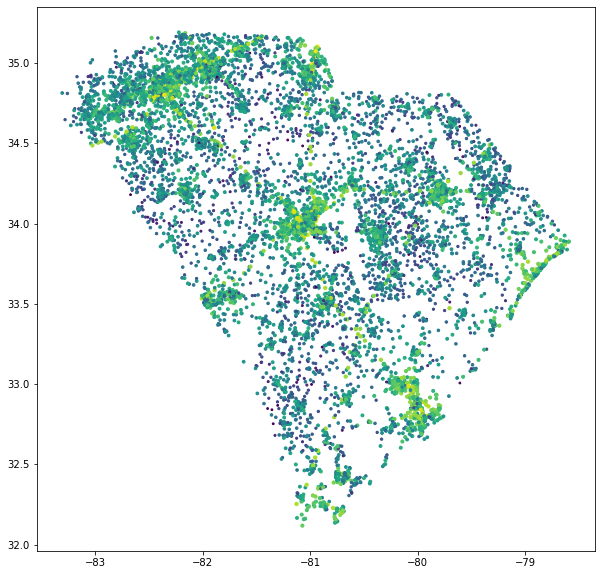

In [272]:
# do some test plotting
test_plot = traffic_df.loc[traffic_df.year == 2018].sample(10000)
x_plot = test_plot.longitude.values
y_plot = test_plot.latitude.values
cmap = plt.get_cmap('jet')
c = np.log(test_plot.average_daily_traffic)
s = np.log(test_plot.average_daily_traffic)

# plt.scatter(x_plot, y_plot, alpha=0.15, s=s, c=c, cmap=cmap)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.scatter(x_plot, y_plot, s=s, c=c)
#plt.scatter([1,2,3], [2,3,4])

That looks like South Carolina! Now we'll prep some home sales data.

### Zillow Sales data by Zip Code

In [42]:
# read in the data
sales_df = pd.read_csv('Sale_Counts_Zip.csv')
sales_df.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,seasAdj
0,61639,10025,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,76.0,33.0,47.0,56.0,35.0,70.0,78.0,66.0,63.0,0
1,84654,60657,Illinois,2,NaN,NaN,NaN,NaN,NaN,NaN,...,91.0,77.0,113.0,157.0,189.0,165.0,186.0,141.0,152.0,0
2,61637,10023,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,45.0,63.0,45.0,66.0,85.0,79.0,90.0,95.0,0
3,91982,77494,Texas,4,56.0,71.0,84.0,95.0,116.0,86.0,...,86.0,112.0,186.0,218.0,200.0,204.0,245.0,226.0,NaN,0
4,84616,60614,Illinois,5,NaN,NaN,NaN,NaN,NaN,NaN,...,75.0,85.0,144.0,163.0,219.0,209.0,204.0,196.0,173.0,0


The data is very wide - sales are recording in columns. Our steps for prepping this data will be to:
1) Filter down to only South Carolina Zip Codes

2) Drop columns we don't care about

3) Convert records from wide to tall format

4) Get the sum of sales per zipcode per year

In [43]:
# filter to only SC
sales_df = sales_df.loc[sales_df.StateName == 'South Carolina']

# drop columns we don't care about and rename columns
sales_df = sales_df.drop(['RegionID', 'StateName', 'seasAdj'], axis=1)
sales_df.rename(columns={'RegionName': 'ZipCode'}, inplace=True)
sales_df = sales_df.set_index(['ZipCode', 'SizeRank'])

In [44]:
sales_df.head()

,,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
ZipCode,SizeRank,,,,,,,,,,,,,,,,,,,,,
29732,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,127.0,75.0,75.0,134.0,140.0,125.0,136.0,128.0,138.0,151.0
29072,227,63.0,89.0,75.0,70.0,76.0,65.0,68.0,47.0,42.0,43.0,...,165.0,88.0,88.0,126.0,132.0,192.0,156.0,180.0,169.0,142.0
29730,287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,119.0,71.0,60.0,91.0,95.0,116.0,111.0,87.0,100.0,107.0
29464,291,58.0,78.0,73.0,88.0,81.0,73.0,57.0,69.0,49.0,35.0,...,76.0,63.0,91.0,94.0,138.0,116.0,135.0,146.0,141.0,NaN
29681,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,99.0,118.0,150.0,129.0,165.0,136.0,151.0,150.0,161.0


In [45]:
# stack all sales into one column
sales_df = sales_df.stack().reset_index()
sales_df.columns = ['ZipCode', 'SizeRank', 'YearMonth', 'Sales']
sales_df.head()

,ZipCode,SizeRank,YearMonth,Sales
0,29732,180,2014-08,127.0
1,29732,180,2014-09,145.0
2,29732,180,2014-10,124.0
3,29732,180,2014-11,121.0
4,29732,180,2014-12,124.0


Keep only years <= 2018

In [46]:
# extract the year out of the Sales record
sales_df['Year'] = sales_df['YearMonth'].str.split('-').str[0]
sales_df = sales_df.loc[sales_df.Year.astype('int') <= 2018]
sales_df.head()

,ZipCode,SizeRank,YearMonth,Sales,Year
0,29732,180,2014-08,127.0,2014
1,29732,180,2014-09,145.0,2014
2,29732,180,2014-10,124.0,2014
3,29732,180,2014-11,121.0,2014
4,29732,180,2014-12,124.0,2014


In [47]:
# yearly sales calculated - sum over ZipCode and year
yearly_sales = sales_df.groupby(['ZipCode', 'SizeRank', 'Year']).Sales.sum()
yearly_sales.tail(10)

ZipCode  SizeRank  Year
29945    12932     2009    20.0
                   2010    20.0
                   2011    25.0
                   2012    30.0
                   2013    23.0
                   2014    23.0
                   2015    26.0
                   2016    14.0
                   2017    23.0
                   2018    17.0
Name: Sales, dtype: float64

### Zip to Lat/Long xref
Now that we have yearly home sales by zipcode, we want to be able to link these home sales to a Lat/Long point.

In [48]:
# read in the data
zip_xref = pd.read_csv('sc-zip-code-latitude-and-longitude.csv')

In [49]:
zip_xref.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint,Unnamed: 8
0,29607,Greenville,SC,34.825592,-82.34099,-5,1,34.825592,-82.34099
1,29164,Wagener,SC,33.659078,-81.40845,-5,1,33.659078,-81.40845
2,29325,Clinton,SC,34.470115,-81.86761,-5,1,34.470115,-81.86761
3,29520,Cheraw,SC,34.688620,-79.92315,-5,1,34.688620,-79.92315
4,29615,Greenville,SC,34.866801,-82.31739,-5,1,34.866801,-82.31739


In [50]:
# merge the zip code to lat/long xref to the yearly sales data
merged_sales = yearly_sales\
    .reset_index()\
    .merge(zip_xref, how='left', left_on='ZipCode', right_on='Zip')

In [51]:
# drop zip codes that have a length less than 5
merged_sales = merged_sales.loc[merged_sales.ZipCode.apply(lambda x: len(str(x)) >= 5)]

In [52]:
# drop columns i don't care about
merged_sales = merged_sales.drop(['Zip','Timezone', 'Daylight savings time flag', 'geopoint', 'Unnamed: 8'], axis=1)

In [53]:
merged_sales.head(10)

,ZipCode,SizeRank,Year,Sales,City,State,Latitude,Longitude
11,29001,17838,2008,10.0,Alcolu,SC,33.76993,-80.17278
12,29001,17838,2009,10.0,Alcolu,SC,33.76993,-80.17278
13,29001,17838,2010,11.0,Alcolu,SC,33.76993,-80.17278
14,29001,17838,2011,8.0,Alcolu,SC,33.76993,-80.17278
15,29001,17838,2012,9.0,Alcolu,SC,33.76993,-80.17278
16,29001,17838,2013,12.0,Alcolu,SC,33.76993,-80.17278
17,29001,17838,2014,10.0,Alcolu,SC,33.76993,-80.17278
18,29001,17838,2015,3.0,Alcolu,SC,33.76993,-80.17278
19,29001,17838,2016,14.0,Alcolu,SC,33.76993,-80.17278
20,29001,17838,2017,12.0,Alcolu,SC,33.76993,-80.17278


In [279]:
merged_sales['Year'] = merged_sales.Year.astype('int')

Text(0.5, 1.0, 'Home sales by Year in SC')

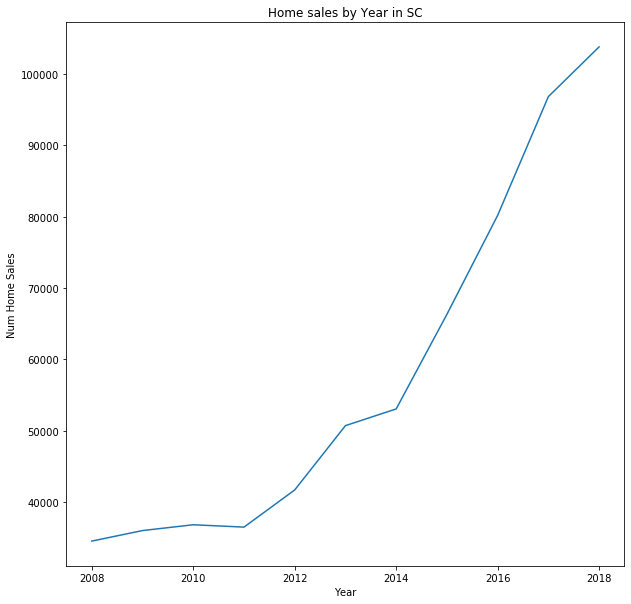

In [286]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_sales.groupby('Year').Sales.sum().plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Num Home Sales')
ax.set_title('Home sales by Year in SC')

Text(0.5, 1.0, 'Home sales by Year and Zip Code in SC')

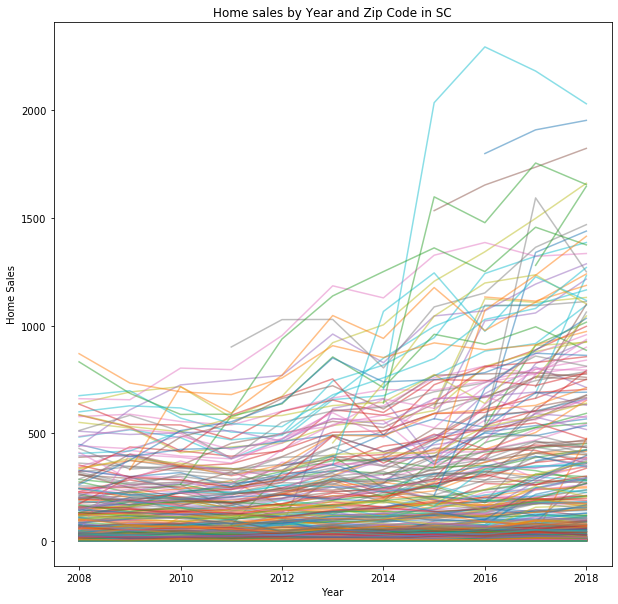

In [289]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for ttl, grp in merged_sales.groupby('ZipCode'):
    ax.plot(grp.Year, grp.Sales, alpha=0.5, label=ttl)
ax.set_xlabel('Year')
ax.set_ylabel('Home Sales')
ax.set_title('Home sales by Year and Zip Code in SC')

At this point I'd like to calculate how far each Zip Code is from each station. 
I searched online for a way to calculate the as-the-crow-flies distance between two lat/long points.
The first reference I found referred to the "haversine" formula, detailed here - https://www.movable-type.co.uk/scripts/latlong.html. 
I found a nice numpy implmentation on Stack Overflow here: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas from derricw.

In order to calculate the distance between each possible combination of points, I will be taking all unique lat/long points from traffic data and crossjoining with all unique lat/long points from zip code data. Then, I will apply the haversine formula to get the linear distance between each pair of points.

In [54]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

Get the unique zips and stations

In [55]:
# get unique zip to lat/long
zip_xref['Latitude'] = zip_xref.Latitude.astype('float')
zip_xref['Longitude'] = zip_xref.Longitude.astype('float')
unique_zip = zip_xref.loc[:, ['Zip', 'Latitude', 'Longitude']].drop_duplicates()

In [56]:
unique_zip.head()

,Zip,Latitude,Longitude
0,29607,34.825592,-82.34099
1,29164,33.659078,-81.40845
2,29325,34.470115,-81.86761
3,29520,34.688620,-79.92315
4,29615,34.866801,-82.31739


In [57]:
# get the unique station/routeid/route number lat/long
unique_station = traffic_df \
    .loc[:, ['station_id', 'route_identifier', 'route_number', 'latitude', 'longitude']] \
    .drop_duplicates()\
    .groupby(['station_id', 'route_identifier', 'route_number'])\
    .head(1)

Cross join zips and stations

In [58]:
# create the cartesian product/crossjoin by merging on a uniform key
unique_zip['key'] = 0
unique_station['key'] = 0

station_zip_xref = unique_station.merge(unique_zip, on='key').drop('key', axis=1)
station_zip_xref.columns = [
        'station_id',
        'route_identifier',
        'route_number',
        'station_lat',
        'station_long',
        'Zip',
        'zip_lat',
        'zip_long'
    ]

station_zip_xref.head(10)

,station_id,route_identifier,route_number,station_lat,station_long,Zip,zip_lat,zip_long
0,100.0,01040018500N,185.0,34.37926,-82.44928,29607,34.825592,-82.340990
1,100.0,01040018500N,185.0,34.37926,-82.44928,29164,33.659078,-81.408450
2,100.0,01040018500N,185.0,34.37926,-82.44928,29325,34.470115,-81.867610
3,100.0,01040018500N,185.0,34.37926,-82.44928,29520,34.688620,-79.923150
4,100.0,01040018500N,185.0,34.37926,-82.44928,29615,34.866801,-82.317390
5,100.0,01040018500N,185.0,34.37926,-82.44928,29336,34.888237,-81.969020
6,100.0,01040018500N,185.0,34.37926,-82.44928,29348,34.888237,-81.969020
7,100.0,01040018500N,185.0,34.37926,-82.44928,29260,34.005992,-80.970766
8,100.0,01040018500N,185.0,34.37926,-82.44928,29708,35.040969,-80.994270
9,100.0,01040018500N,185.0,34.37926,-82.44928,29730,34.914611,-81.012500


In [59]:
station_zip_xref.shape

(6777082, 8)

Now we can calculate the difference in km between each station and each zip code!

In [60]:
station_zip_xref['distance_km'] = haversine_np(
    station_zip_xref.station_long.values,
    station_zip_xref.station_lat.values,
    station_zip_xref.zip_long.values,
    station_zip_xref.zip_lat.values
)

In [61]:
station_zip_xref.head(10)

,station_id,route_identifier,route_number,station_lat,station_long,Zip,zip_lat,zip_long,distance_km
0,100.0,01040018500N,185.0,34.37926,-82.44928,29607,34.825592,-82.340990,50.578065
1,100.0,01040018500N,185.0,34.37926,-82.44928,29164,33.659078,-81.408450,124.879647
2,100.0,01040018500N,185.0,34.37926,-82.44928,29325,34.470115,-81.867610,54.265474
3,100.0,01040018500N,185.0,34.37926,-82.44928,29520,34.688620,-79.923150,233.786265
4,100.0,01040018500N,185.0,34.37926,-82.44928,29615,34.866801,-82.317390,55.504245
5,100.0,01040018500N,185.0,34.37926,-82.44928,29336,34.888237,-81.969020,71.605047
6,100.0,01040018500N,185.0,34.37926,-82.44928,29348,34.888237,-81.969020,71.605047
7,100.0,01040018500N,185.0,34.37926,-82.44928,29260,34.005992,-80.970766,142.088760
8,100.0,01040018500N,185.0,34.37926,-82.44928,29708,35.040969,-80.994270,151.896534
9,100.0,01040018500N,185.0,34.37926,-82.44928,29730,34.914611,-81.012500,144.191827


Now, we can calculate the home sales within a certain radius of a station for the current year or previous year and see if that has any bearing on traffic patterns.

In [62]:
merged_sales.head()

,ZipCode,SizeRank,Year,Sales,City,State,Latitude,Longitude
11,29001,17838,2008,10.0,Alcolu,SC,33.76993,-80.17278
12,29001,17838,2009,10.0,Alcolu,SC,33.76993,-80.17278
13,29001,17838,2010,11.0,Alcolu,SC,33.76993,-80.17278
14,29001,17838,2011,8.0,Alcolu,SC,33.76993,-80.17278
15,29001,17838,2012,9.0,Alcolu,SC,33.76993,-80.17278


For example, sum of home sales within a 16 km radius from station

In [63]:
station_zip_xref \
    .loc[station_zip_xref.distance_km <= 16, ['Zip', 'distance_km', 'station_id', 'route_identifier', 'route_number']] \
    .merge(merged_sales[['ZipCode', 'Year', 'Sales']], left_on=['Zip'], right_on=['ZipCode']) \
    .groupby(['station_id', 'route_identifier', 'route_number', 'Year']) \
    .Sales \
    .sum() \
    .reset_index()\
    .head()

,station_id,route_identifier,route_number,Year,Sales
0,100.0,01040018500N,185.0,2008,336.0
1,100.0,01040018500N,185.0,2009,244.0
2,100.0,01040018500N,185.0,2010,267.0
3,100.0,01040018500N,185.0,2011,268.0
4,100.0,01040018500N,185.0,2012,252.0


In [64]:
def calc_home_sales_in_radius(sales_df, station_zip_xref, radius_cutoff):
    filtered_zips = station_zip_xref.loc[station_zip_xref.distance_km <= radius_cutoff]
    sales_per_station = station_zip_xref.merge(sales_df[['ZipCode', 'Year', 'Sales']], left_on=['Zip'], right_on=['ZipCode'])
    sales_per_station = sales_per_station \
        .groupby(['station_id', 'route_identifier', 'route_number', 'Year']) \
        .Sales \
        .sum() \
        .reset_index()

    return sales_per_station

In [65]:
sales_per_station = calc_home_sales_in_radius(merged_sales, station_zip_xref, 15)

In [66]:
sales_per_station.head()

,station_id,route_identifier,route_number,Year,Sales
0,100.0,01040018500N,185.0,2008,34205.0
1,100.0,01040018500N,185.0,2009,35604.0
2,100.0,01040018500N,185.0,2010,36403.0
3,100.0,01040018500N,185.0,2011,36065.0
4,100.0,01040018500N,185.0,2012,41082.0


In [67]:
sales_per_station = sales_per_station.rename(columns={'Year':'year'})

In [68]:
sales_per_station['year'] = sales_per_station.year.astype('float')

Now let's merge the sales data back into our traffic dataframe

In [69]:
traffic_with_sales = traffic_df.merge(sales_per_station, on=['station_id', 'route_identifier', 'route_number', 'year'])

In [70]:
traffic_with_sales.head()

,average_daily_traffic,county_id,county_name,gmrotation,latitude,longitude,route_identifier,route_number,route_leg_beginmile,route_leg_endmile,route_mile_point,route_leg_descrip,route_type,route_type_number,station_id,year,pct_changed,Sales
0,1200.0,1.0,ABBEVILLE,8.337633e-07,34.37926,-82.44928,01040018500N,185.0,0.0,2.58,1.096,County Line - ANDERSON TO SC 20 (20),SC,4.0,100.0,2009.0,NaN,35604.0
1,1050.0,1.0,ABBEVILLE,8.337633e-07,34.37926,-82.44928,01040018500N,185.0,0.0,2.58,1.096,County Line - ANDERSON TO SC 20 (20),SC,4.0,100.0,2010.0,-0.125,36403.0
2,1050.0,1.0,ABBEVILLE,8.337633e-07,34.37926,-82.44928,01040018500N,185.0,0.0,2.58,1.096,County Line - ANDERSON TO SC 20 (20),SC,4.0,100.0,2011.0,0.000,36065.0
3,1050.0,1.0,ABBEVILLE,6.661738e-01,34.37926,-82.44928,01040018500N,185.0,0.0,2.58,1.096,County Line - ANDERSON TO SC 20 (20),SC,4.0,100.0,2012.0,0.000,41082.0
4,1050.0,1.0,ABBEVILLE,8.337633e-07,34.37926,-82.44928,01040018500N,185.0,0.0,2.58,1.096,County Line - ANDERSON TO SC 20 (20),SC,4.0,100.0,2013.0,0.000,49883.0


Alright! Time for some plots!

In [71]:
traffic_with_sales['county_name'] = traffic_with_sales.county_name.str.upper()
traffic_with_sales.county_name.unique()

array(['ABBEVILLE', 'ANDERSON', 'BERKELEY', 'COLLETON', 'GREENVILLE',
       'HORRY', 'KERSHAW', 'MCCORMICK', 'OCONEE', 'ORANGEBURG', 'SALUDA',
       'AIKEN', 'ALLENDALE', 'BAMBERG', 'BARNWELL', 'BEAUFORT', 'CALHOUN',
       'CHARLESTON', 'CHEROKEE', 'CHESTER', 'CHESTERFIELD', 'CLARENDON',
       'DARLINGTON', 'DILLON', 'DORCHESTER', 'EDGEFIELD', 'FAIRFIELD',
       'FLORENCE', 'GEORGETOWN', 'GREENWOOD', 'HAMPTON', 'JASPER',
       'LANCASTER', 'LAURENS', 'LEE', 'LEXINGTON', 'MARION', 'MARLBORO',
       'NEWBERRY', 'RICHLAND', 'SPARTANBURG', 'SUMTER', 'UNION',
       'WILLIAMSBURG', 'YORK', 'PICKENS', 'MALBORO', 'ORANGBURG'],
      dtype=object)

County histograms

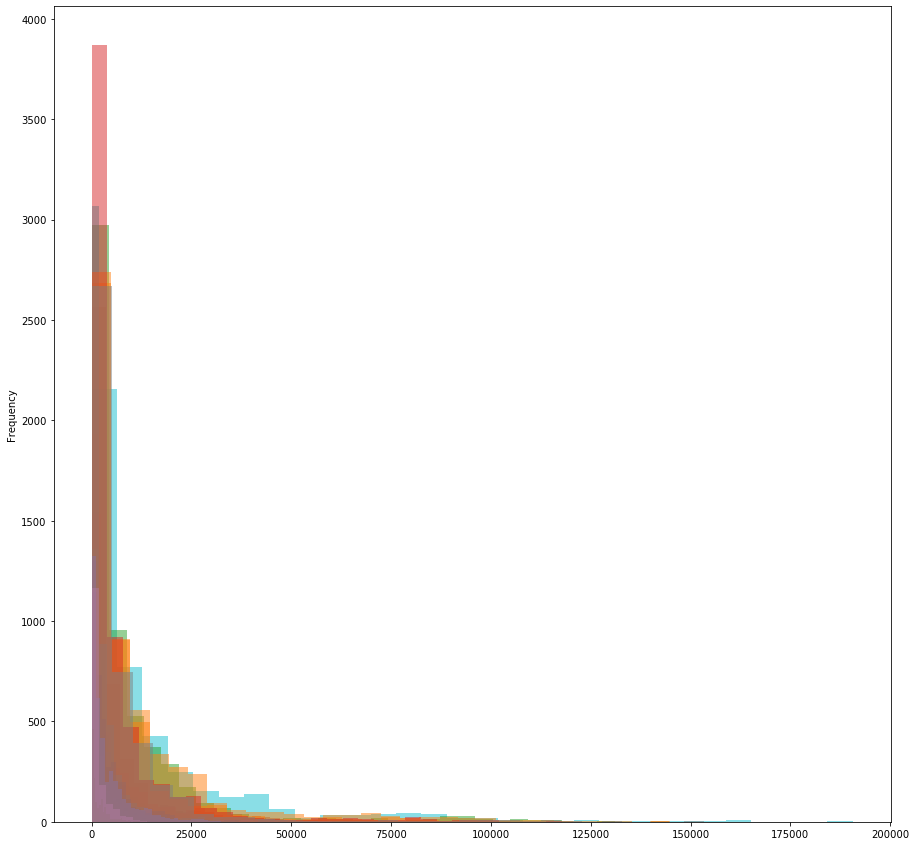

In [296]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
for county, grp in traffic_with_sales.groupby('county_name'):
    grp.average_daily_traffic.plot(kind='hist', bins=30, ax=ax, alpha=0.5, label=county)

Find average of average daily traffic by county and year - average across all stations in county per year.
Take the top 15 stations by 2018 numbers.
We will exclude interstate traffic.

In [134]:
county_avg = traffic_with_sales\
    .loc[traffic_with_sales.route_type != "I"]\
    .groupby(['county_name', 'year'])\
    .average_daily_traffic\
    .mean()\
    .reset_index()

top_counties = county_avg\
    .sort_values(['year', 'average_daily_traffic'], ascending=[False, False])\
    .head(15)\
    .county_name\
    .unique()
    
county_avg = county_avg.loc[county_avg.county_name.isin(top_counties)]

In [135]:
county_avg.head()

,county_name,year,average_daily_traffic
10,AIKEN,2009.0,4793.877551
11,AIKEN,2010.0,4781.982759
12,AIKEN,2011.0,4756.401384
13,AIKEN,2012.0,4659.523810
14,AIKEN,2013.0,4569.217687


Plot county avg traffic numbers.

In [155]:
county_data = []
for county in county_avg.county_name.unique():
    trace = go.Scatter(
        x = county_avg.year.unique(),
        y = county_avg.loc[county_avg.county_name == county, 'average_daily_traffic'].values,
        # hovertext = county,
        name = county
        # hovername
    )
    county_data.append(trace)

county_layout = go.Layout(
    title = dict(
        text = 'Average Daily Traffic by County and Year in SC, excluding Interstate Traffic',
        x = 0.5
    ),
    xaxis_title = 'Year',
    yaxis_title = 'Average Daily Traffic',
    showlegend = True,
    margin = dict(l=25, r=20, t=35, b=30),
    width = 900,
    height = 600
)


fig = go.Figure(data=county_data, layout=county_layout)

py.iplot(fig, filename='county-traffic')

Look at pct change by county

In [137]:
county_avg['pct_chg'] = county_avg\
    .sort_values(['county_name', 'year'])\
    .groupby('county_name')\
    .average_daily_traffic\
    .pct_change()

In [138]:
county_avg.head()

,county_name,year,average_daily_traffic,pct_chg
10,AIKEN,2009.0,4793.877551,NaN
11,AIKEN,2010.0,4781.982759,-0.002481
12,AIKEN,2011.0,4756.401384,-0.005350
13,AIKEN,2012.0,4659.523810,-0.020368
14,AIKEN,2013.0,4569.217687,-0.019381


Plot

In [139]:
county_data = []
for county in county_avg.county_name.unique():
    trace = go.Scatter(
        x = county_avg.year.unique(),
        y = county_avg.loc[(county_avg.county_name == county) & (county_avg.year > 2009), 'pct_chg'].values,
        # hovertext = county,
        name = county
        # hovername
    )
    county_data.append(trace)

county_layout = go.Layout(
    title = dict(
        text = 'Pct Change Average Daily Traffic by County and Year in SC',
        x = 0.5
    ),
    xaxis_title = 'Year',
    yaxis_title = 'Average Daily Traffic',
    showlegend = True,
    margin = dict(l=25, r=20, t=35, b=30),
    width = 900,
    height = 600
)


fig = go.Figure(data=county_data, layout=county_layout)

py.iplot(fig, filename='county-traffic')

Plot county max, not county avg

In [141]:
county_max = traffic_with_sales\
    .loc[traffic_with_sales.route_type != "I"]\
    .groupby(['county_name', 'year'])\
    .average_daily_traffic\
    .max()\
    .reset_index()


top_counties = county_max\
    .sort_values(['year', 'average_daily_traffic'], ascending=[False, False])\
    .head(15)\
    .county_name\
    .unique()
    
county_max = county_max.loc[county_max.county_name.isin(top_counties)]

In [142]:
county_data = []
for county in county_max.county_name.unique():
    trace = go.Scatter(
        x = county_max.year.unique(),
        y = county_max.loc[(county_max.county_name == county), 'average_daily_traffic'].values,
        # hovertext = county,
        name = county
        # hovername
    )
    county_data.append(trace)

county_layout = go.Layout(
    title = dict(
        text = 'Max Average Daily Traffic by County and Year in SC, excluding Interstate Traffic',
        x = 0.5
    ),
    xaxis_title = 'Year',
    yaxis_title = 'Average Daily Traffic',
    showlegend = True,
    margin = dict(l=25, r=20, t=35, b=30),
    width = 900,
    height = 600
)


fig = go.Figure(data=county_data, layout=county_layout)

py.iplot(fig, filename='county-traffic')

The avg per county is much higher than the max, as expected. There are obviously stations within these counties that experience much lower average daily traffic than the most high-traffic areas. <br>
Charleston county is by far the most heavily trafficked area in SC

We'll average by route number next.

In [160]:
route_avg = traffic_with_sales\
    .groupby(['route_type', 'route_number', 'year'])\
    .average_daily_traffic\
    .mean()\
    .reset_index()

top_routes = route_avg\
    .sort_values(['year', 'average_daily_traffic'], ascending=[False, False])\
    .head(20)\
    .drop(['year', 'average_daily_traffic'], axis=1)

top_routes.head()

,route_type,route_number
39,I,85.0
29,I,77.0
59,I,126.0
19,I,26.0
98,I,526.0


In [161]:
route_avg = route_avg.merge(top_routes, on=['route_type', 'route_number'])

In [162]:
route_avg['route'] = route_avg.route_type + '-' + route_avg.route_number.astype('int').astype('str')
route_avg.head()

,route_type,route_number,year,average_daily_traffic,route
0,I,20.0,2009.0,48421.621622,I-20
1,I,20.0,2010.0,49432.432432,I-20
2,I,20.0,2011.0,48975.675676,I-20
3,I,20.0,2012.0,48959.459459,I-20
4,I,20.0,2013.0,49215.789474,I-20


In [163]:
route_data = []
for route in route_avg.route.unique():
    trace = go.Scatter(
        x = route_avg.year.unique(),
        y = route_avg.loc[(route_avg.route == route), 'average_daily_traffic'].values,
        # hovertext = county,
        name = route
        # hovername
    )
    route_data.append(trace)

route_layout = go.Layout(
    title = dict(
        text = 'Avg Average Daily Traffic by Route and Year in SC',
        x = 0.5
    ),
    xaxis_title = 'Year',
    yaxis_title = 'Average Daily Traffic',
    showlegend = True,
    margin = dict(l=25, r=20, t=35, b=30),
    width = 900,
    height = 600
)


fig = go.Figure(data=route_data, layout=route_layout)

py.iplot(fig, filename='route-traffic')

In [164]:
route_max = traffic_with_sales\
    .groupby(['route_type', 'route_number', 'year'])\
    .average_daily_traffic\
    .max()\
    .reset_index()

top_routes = route_avg\
    .sort_values(['year', 'average_daily_traffic'], ascending=[False, False])\
    .head(20)\
    .drop(['year', 'average_daily_traffic'], axis=1)

top_routes.head()

,route_type,route_number,route
39,I,85.0,I-85
29,I,77.0,I-77
59,I,126.0,I-126
19,I,26.0,I-26
79,I,526.0,I-526


In [157]:
route_max = route_max.merge(top_routes, on=['route_type', 'route_number'])
route_max['route'] = route_max.route_type + '-' + route_max.route_number.astype('int').astype('str')
route_max.head()

,route_type,route_number,year,average_daily_traffic,route
0,I,20.0,2009.0,98700.0,I-20
1,I,20.0,2010.0,100700.0,I-20
2,I,20.0,2011.0,100100.0,I-20
3,I,20.0,2012.0,100500.0,I-20
4,I,20.0,2013.0,102700.0,I-20


In [158]:
route_data = []
for route in route_max.route.unique():
    trace = go.Scatter(
        x = route_max.year.unique(),
        y = route_max.loc[(route_max.route == route), 'average_daily_traffic'].values,
        # hovertext = county,
        name = route
        # hovername
    )
    route_data.append(trace)

route_layout = go.Layout(
    title = dict(
        text = 'Max Average Daily Traffic by Route and Year in SC',
        x = 0.5
    ),
    xaxis_title = 'Year',
    yaxis_title = 'Average Daily Traffic',
    showlegend = True,
    margin = dict(l=25, r=20, t=35, b=30),
    width = 900,
    height = 600
)


fig = go.Figure(data=route_data, layout=route_layout)

py.iplot(fig, filename='route-traffic')

Unsurprisingly, the Interstates are the most heavily trafficked routes in SC. 

Now let's see if we can find any correlation with home sales within 15km of station and average daily traffic

In [225]:
from scipy.stats.stats import pearsonr, spearmanr
from scipy.stats import percentileofscore

traffic_sales_corr = traffic_with_sales\
    .groupby(['station_id', 'route_identifier', 'route_number'])\
    .apply(lambda grp: pearsonr(grp.average_daily_traffic, grp.Sales)[0])\
    .reset_index()

In [226]:
traffic_sales_corr.columns = ['station_id', 'route_identifier', 'route_number', 'corr_coeff']

Text(0, 0.5, 'Count')

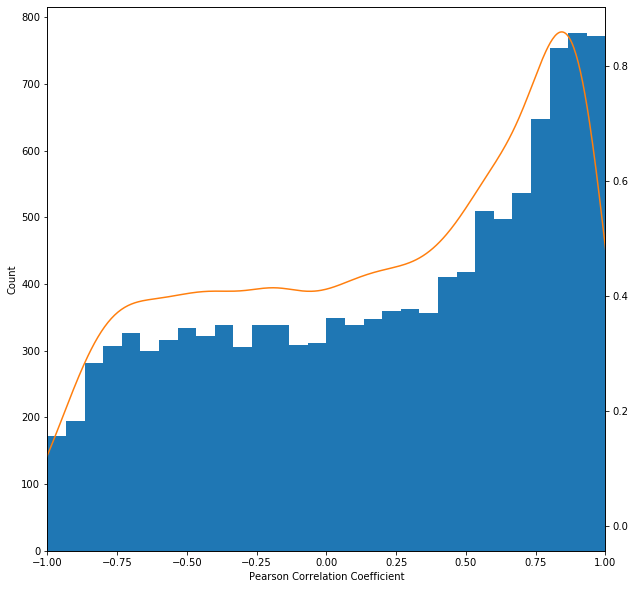

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
traffic_sales_corr.corr_coeff.hist(bins=30, ax=ax)
traffic_sales_corr.corr_coeff.plot(kind='kde', ax=ax, secondary_y=True)
ax.set_xlim([-1, 1])
ax.set_xlabel('Pearson Correlation Coefficient')
ax.set_ylabel('Count')

In [228]:
percentileofscore(traffic_sales_corr.corr_coeff.dropna(), 0.2)

46.35700511444622

In [229]:
percentileofscore(traffic_sales_corr.corr_coeff.dropna(), 0.5)

60.51815209189235

Avg Daily Traffic at 55% of stations have at least a modest correlation (0.2) with home sales in a 15km radius of station within the same year.
40% of stations have a strong correlation (>= 0.5).
We also have stations that have strong negative correlations with home sales! <br>

Now we'll look at correlations with home sales from two years prior.

In [238]:
traffic_sales_corr_prev = traffic_with_sales\
    .sort_values(['station_id', 'route_identifier', 'route_number', 'year'])\
    .groupby(['station_id', 'route_identifier', 'route_number'])\
    .apply(lambda grp: pearsonr(grp.average_daily_traffic[2:], grp.Sales.shift(2)[2:])[0])\
    .reset_index()

In [243]:
traffic_sales_corr_prev.columns = ['station_id', 'route_identifier', 'route_number', 'corr_coeff']

Text(0, 0.5, 'Count')

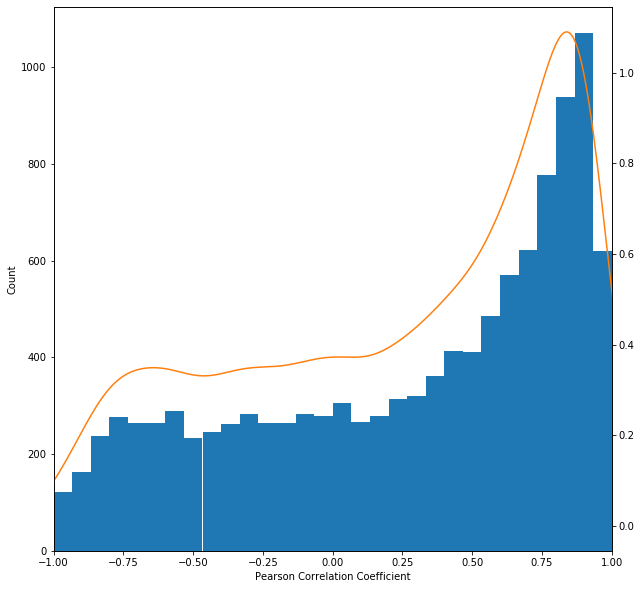

In [240]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
traffic_sales_corr_prev.corr_coeff.hist(bins=30, ax=ax)
traffic_sales_corr_prev.corr_coeff.plot(kind='kde', ax=ax, secondary_y=True)
ax.set_xlim([-1, 1])
ax.set_xlabel('Pearson Correlation Coefficient')
ax.set_ylabel('Count')

In [241]:
percentileofscore(traffic_sales_corr_prev.corr_coeff.dropna(), 0.2)

39.87462998432875

In [242]:
percentileofscore(traffic_sales_corr_prev.corr_coeff.dropna(), 0.5)

53.822044227755526

Slight increase in percent of stations that have some correlation with home sales.
Avg Daily Traffic at 60% of stations have at least a modest correlation (0.2) with home sales in a 15km radius of station within the same year.
47% of stations have a strong correlation (>= 0.5). <br>
Further analysis and examination of segments within the dataset (e.g. route type, etc) would be needed before anything conclusive can be said. <br>
Additionally, the radius in km at which home sales are calculated could be tweaked.

In [247]:
peek = traffic_sales_corr_prev.merge(traffic_with_sales, on=['station_id', 'route_identifier', 'route_number'])

Text(0.5, 0.98, 'Dist of Correlation Coeff for Avg Daily Traffic and Home Sales 2 Years Prior By Route Type')

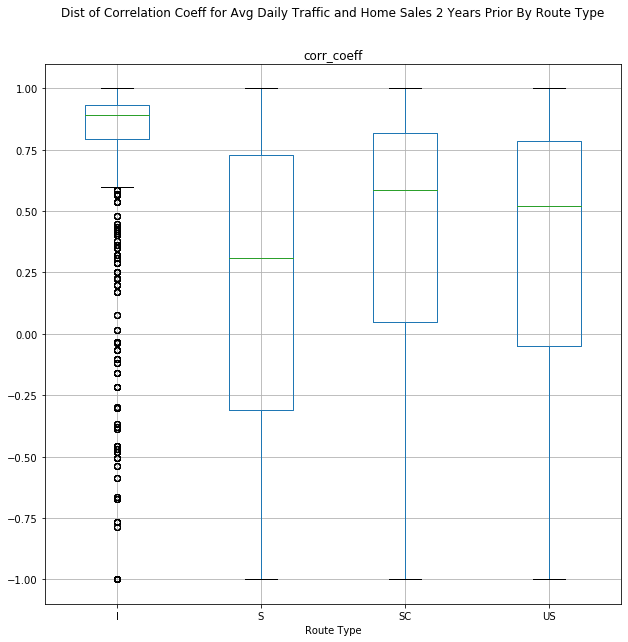

In [266]:
peek.boxplot(column='corr_coeff', by='route_type', figsize=(10, 10))

ax = plt.gca()
ax.set_xlabel('Route Type')
plt.suptitle('Dist of Correlation Coeff for Avg Daily Traffic and Home Sales 2 Years Prior By Route Type')

Text(0.5, 0.98, '50th Percentile Correlation Coeff for Avg Daily Traffic and Home Sales 2 Years Prior By County')

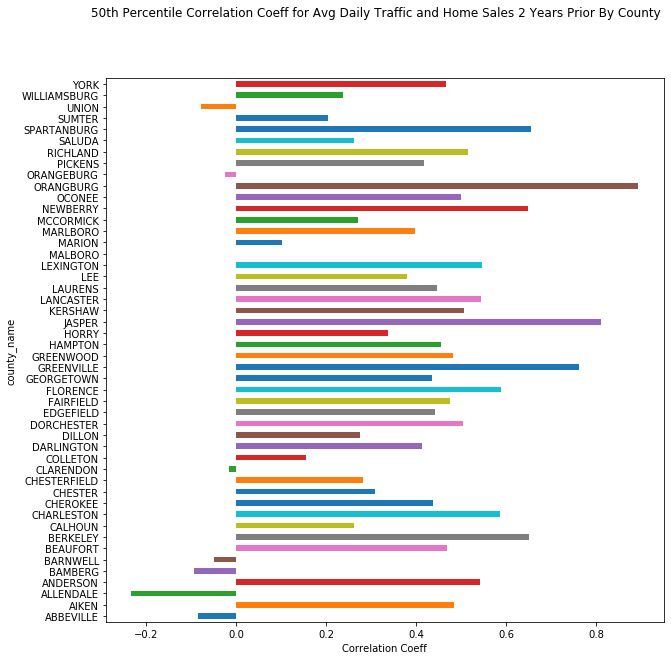

In [257]:
peek.groupby('county_name')\
    .corr_coeff\
    .describe()['50%']\
    .plot(kind='barh', figsize=(10, 10))

ax = plt.gca()
ax.set_xlabel('Correlation Coeff')
plt.suptitle('50th Percentile Correlation Coeff for Avg Daily Traffic and Home Sales 2 Years Prior By County')